# Machine Learning Project 1: Perceptron, Adaline, SVM, and Logistic Regression


In this project, we will be analyzing the adult.csv dataset to predict and classify income based on demographic and life experience variables. The objective is to practically apply the machine learning algorithms and optimization techniques covered in class to a real-world dataset. 

Import the necessary packages:

In [1]:
from sklearn.linear_model import Perceptron as SklearnPerceptron 
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import accuracy_score 
import pandas as pd 
import numpy as np 
from scipy import sparse 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer 
from sklearn import set_config 
from sklearn.linear_model import Perceptron, SGDRegressor 
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


Load in the data:

In [2]:
train_df = pd.read_csv("project_adult.csv")
validation_df = pd.read_csv("project_validation_inputs.csv")

Perform basic data cleaning:

In [3]:
# NAME THE FIRST COLUMN (it is unnamed originally) (IS THIS INDEX??) We still do not know! 

train_df = train_df.rename(columns={"Unnamed: 0": "index"})
validation_df = validation_df.rename(columns={"Unnamed: 0": "index"})

# CLEAN THE DATA:
def basic_clean(df):
    # standardize column names
    df.columns = (
        df.columns
            .str.strip() # remove leading/trailing spaces
            .str.lower() # convert to lowercase
            .str.replace(" ", "_") # replace spaces with underscore
            .str.replace("-", "_") # replace hyphens with underscore
    )
    df = df.replace("?", np.nan) # replace "?" with NaN within data
    # clean data within columns
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].str.lower()# convert to lowercase
        df[col] = df[col].str.strip() # remove leading/trailing spaces
        df[col] = df[col].str.replace("-", "_") # replace hyphens with underscore
    return df

# NORMALIZE INCOME LABELS:
train_df["income"] = train_df["income"].str.strip()
# adjust income values to be binary
    # GREATER THAN OR EQUAL TO 50K = 0
    # LESS THAN 50K = 1
train_df["income"] = train_df["income"].replace({
    "<=50K": 0, "<=50K.": 0,
    ">50K": 1,  ">50K.": 1
})

In [4]:
# APPLY THE CLEANING FUNCTION:
train_df = basic_clean(train_df)
validation_df = basic_clean(validation_df)

EDA:

In [5]:
# print shape
print("Train shape:", train_df.shape)
print("Validation shape:", validation_df.shape)

Train shape: (26048, 16)
Validation shape: (6513, 15)


In [6]:
train_df

,index,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,5514,33,local_gov,198183,bachelors,13,never_married,prof_specialty,not_in_family,white,female,0,0,50,united_states,1
1,19777,36,private,86459,assoc_voc,11,married_civ_spouse,exec_managerial,husband,white,male,0,1887,50,united_states,1
2,10781,58,self_emp_not_inc,203039,9th,5,separated,craft_repair,not_in_family,white,male,0,0,40,united_states,0
3,32240,21,private,180190,assoc_voc,11,married_civ_spouse,farming_fishing,husband,white,male,0,0,46,united_states,0
4,9876,27,private,279872,some_college,10,divorced,other_service,not_in_family,white,male,0,0,40,united_states,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,29802,47,private,359461,bachelors,13,married_civ_spouse,craft_repair,husband,white,male,0,0,40,united_states,0
26044,5390,31,private,147215,12th,8,divorced,other_service,unmarried,white,female,0,0,21,united_states,0
26045,860,18,private,216284,11th,7,never_married,adm_clerical,own_child,white,female,0,0,20,united_states,0
26046,15795,50,self_emp_not_inc,54261,hs_grad,9,married_civ_spouse,farming_fishing,husband,white,male,0,0,84,united_states,0


In [7]:
# print number of NAs in training data
print("\nMissing count per variable in training data:")
print(train_df.isna().sum())


Missing count per variable in training data:
index                0
age                  0
workclass         1447
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     458
income               0
dtype: int64


In [8]:
# print number of NAs in validation data
print("\nMissing count per variable in validation data:")
print(validation_df.isna().sum())


Missing count per variable in validation data:
index               0
age                 0
workclass         389
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        389
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    125
dtype: int64


In [9]:
# show each level of education, the number associated with it, and count of each for better understanding
edu_counts = (
    train_df.groupby(["education_num", "education"])
            .size()                               # counts
            .reset_index(name="count")            # put into a column
            .sort_values("education_num")         # orders by the numeric code
)

#print
print(edu_counts.to_string(index=False))

 education_num    education  count
             1    preschool     41
             2      1st_4th    145
             3      5th_6th    271
             4      7th_8th    505
             5          9th    399
             6         10th    750
             7         11th    950
             8         12th    335
             9      hs_grad   8416
            10 some_college   5806
            11    assoc_voc   1109
            12   assoc_acdm    869
            13    bachelors   4302
            14      masters   1354
            15  prof_school    460
            16    doctorate    336


Encoding Categorical Values:

In [10]:
# separate target from features (TRAIN ONLY)
y_train = train_df["income"] # target
X_train = train_df.drop(columns=["income"])

In [11]:
# IDENTIFY COLUMN TYPES: 
categorical_cols = X_train.select_dtypes(include=["object"]).columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# print
print("Categorical columns:", categorical_cols.tolist())
print("Numerical columns:", numerical_cols.tolist())

Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Numerical columns: ['index', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [12]:
# DEFINE TRANSFORMERS (processing steps):

"""
Here we are going to simply impute the missing values with median and mode values. 
In practice, this can be problematic, as we are assuming values to be MAR (missing at random), 
which is not always the case. More sophisticated methods can be used, 
but for simplicity we will use this approach.
"""

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # fill NaN with most common
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # fill NaN with median
    ("scaler", StandardScaler()) # standardize
])

In [13]:
# COMBINE INTO PREPROCESSER
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [14]:
# FIT ON TRAINING, TRANSFORM BOTH
X_train_processed = preprocessor.fit_transform(X_train)
X_validation_processed = preprocessor.transform(validation_df)

print("Processed training shape:", X_train_processed.shape)
print("Processed validation shape:", X_validation_processed.shape)

Processed training shape: (26048, 106)
Processed validation shape: (6513, 106)


In [15]:
# CHECK FOR NAs:
def has_nan_or_inf(X):
    data = X.data if sparse.issparse(X) else X
    return np.isnan(data).any(), np.isinf(data).any()

print("Train processed:  NA/Inf:", has_nan_or_inf(X_train_processed))
print("Validation processed:  NA/Inf:", has_nan_or_inf(X_validation_processed))

Train processed:  NA/Inf: (False, False)
Validation processed:  NA/Inf: (False, False)


# Perceptron and Adaline Modelling

Best Perceptron epoch by TRAIN misclassifications: 14 (miscls=4299)
Best Adaline   epoch by TRAIN MSE:                23 (MSE=0.115943)


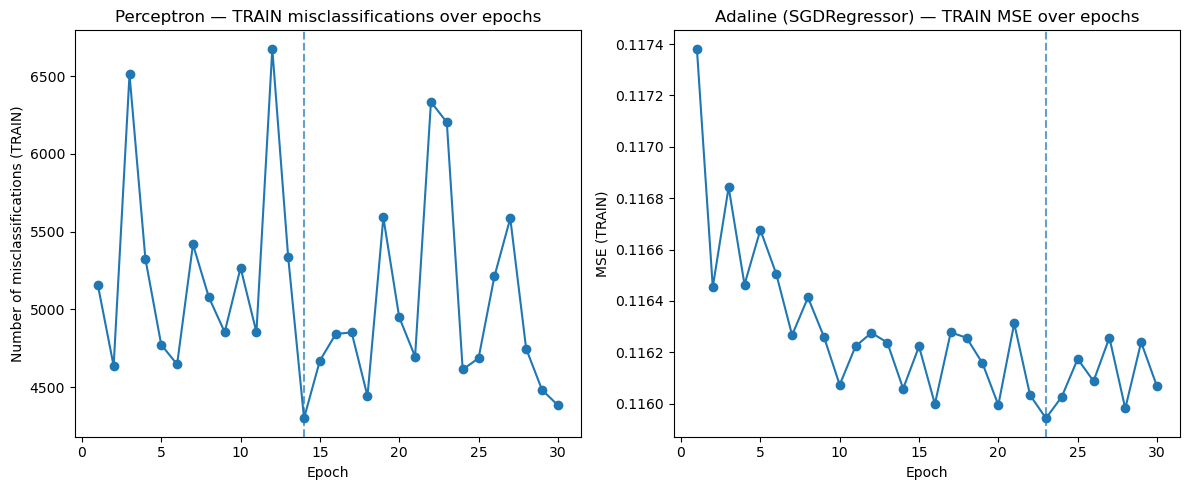

Perceptron (chosen epoch 14) TRAIN accuracy: 0.8198  miscls=4694
Adaline   (chosen epoch 23) TRAIN accuracy: 0.8404  miscls=4156 (threshold=0.5)
Saved Group_11_Perceptron_PredictedOutputs.csv
Saved Group_11_Adaline_PredictedOutputs.csv


In [16]:
N_EPOCHS  = 30       # how many passes through the training set
THRESH    = 0.5      # Adaline threshold to turn raw scores into 0/1 class labels
RNG_BASE  = 123      # seed base for reproducible shuffles
# -----------------------------------------

# ---------- inputs from your preprocessing ----------
Xtr_full = X_train_processed                     # features (already processed)
ytr_full = pd.Series(y_train).astype(int).values # labels as ints {0,1}
classes   = np.array([0, 1])                     # needed by Perceptron on first partial_fit
# sanity check
assert set(np.unique(ytr_full)).issubset({0,1}), "y_train must be binary {0,1}"

# ---------- build fresh models (1-epoch-per-partial_fit) ----------
perc = Perceptron(max_iter=1, tol=None, random_state=42)
try:
    adal = SGDRegressor(loss="squared_error", max_iter=1, tol=None, random_state=42)
except TypeError:  # older sklearn fallback
    adal = SGDRegressor(loss="squared_loss", max_iter=1, tol=None, random_state=42)

# storage for learning curves
perc_mis_per_epoch  = []  # number of misclassifications on TRAIN
adal_mse_per_epoch  = []  # MSE on TRAIN

# ---------- training loop across epochs (FULL training set) ----------
for epoch in range(N_EPOCHS):
    # (optional) shuffle order each epoch — same data, different pass order
    order = np.random.RandomState(RNG_BASE + epoch).permutation(len(ytr_full))
    Xe, ye = Xtr_full[order], ytr_full[order]

    # Perceptron one more epoch of learning
    if epoch == 0:
        perc.partial_fit(Xe, ye, classes=classes)
    else:
        perc.partial_fit(Xe, ye)

    # Adaline one more epoch of learning (SGD on squared loss)
    if epoch == 0:
        adal.partial_fit(Xe, ye)
    else:
        adal.partial_fit(Xe, ye)

    # ---- metrics on FULL training set (what the spec asks to plot) ----
    # Perceptron: number of misclassifications
    yhat_p = perc.predict(Xtr_full)
    mis_p  = int((yhat_p != ytr_full).sum())
    perc_mis_per_epoch.append(mis_p)

    # Adaline: mean squared error on raw outputs
    yhat_a_raw = adal.predict(Xtr_full)
    mse_a      = mean_squared_error(ytr_full, yhat_a_raw)
    adal_mse_per_epoch.append(mse_a)

# ---------- choose best epochs by the required TRAIN metrics ----------
best_ep_perc = int(np.argmin(perc_mis_per_epoch)) + 1  # +1 -> human-friendly (1..N)
best_ep_adal = int(np.argmin(adal_mse_per_epoch)) + 1

print(f"Best Perceptron epoch by TRAIN misclassifications: {best_ep_perc} "
      f"(miscls={perc_mis_per_epoch[best_ep_perc-1]})")
print(f"Best Adaline   epoch by TRAIN MSE:                {best_ep_adal} "
      f"(MSE={adal_mse_per_epoch[best_ep_adal-1]:.6f})")

# ---------- plot learning curves (TRAIN vs epoch) ----------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, N_EPOCHS+1), perc_mis_per_epoch, marker='o')
plt.axvline(best_ep_perc, linestyle='--', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Number of misclassifications (TRAIN)")
plt.title("Perceptron — TRAIN misclassifications over epochs")

plt.subplot(1,2,2)
plt.plot(range(1, N_EPOCHS+1), adal_mse_per_epoch, marker='o')
plt.axvline(best_ep_adal, linestyle='--', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("MSE (TRAIN)")
plt.title("Adaline (SGDRegressor) — TRAIN MSE over epochs")

plt.tight_layout()
plt.show()

# ---------- retrain FRESH models up to best epochs on FULL training ----------
perc_final = Perceptron(max_iter=1, tol=None, random_state=42)
try:
    adal_final = SGDRegressor(loss="squared_error", max_iter=1, tol=None, random_state=42)
except TypeError:
    adal_final = SGDRegressor(loss="squared_loss", max_iter=1, tol=None, random_state=42)

for e in range(best_ep_perc):
    if e == 0: perc_final.partial_fit(Xtr_full, ytr_full, classes=classes)
    else:      perc_final.partial_fit(Xtr_full, ytr_full)

for e in range(best_ep_adal):
    if e == 0: adal_final.partial_fit(Xtr_full, ytr_full)
    else:      adal_final.partial_fit(Xtr_full, ytr_full)


# ---------- report TRAIN accuracy of the chosen models ----------
yhat_perc_train = perc_final.predict(Xtr_full)
train_acc_perc  = accuracy_score(ytr_full, yhat_perc_train)
miscls_perc     = int((yhat_perc_train != ytr_full).sum())

yhat_adal_train = (adal_final.predict(Xtr_full) >= THRESH).astype(int)
train_acc_adal  = accuracy_score(ytr_full, yhat_adal_train)
miscls_adal     = int((yhat_adal_train != ytr_full).sum())

print(f"Perceptron (chosen epoch {best_ep_perc}) "
      f"TRAIN accuracy: {train_acc_perc:.4f}  "
      f"miscls={miscls_perc}")
print(f"Adaline   (chosen epoch {best_ep_adal}) "
      f"TRAIN accuracy: {train_acc_adal:.4f}  "
      f"miscls={miscls_adal} (threshold={THRESH})")


# ---------- make VALIDATION predictions & save CSVs (exact names) ----------
# Perceptron -> class labels directly
val_pred_perc = perc_final.predict(X_validation_processed)
pd.DataFrame({"pred": val_pred_perc}).to_csv(
    f"Group_11_Perceptron_PredictedOutputs.csv", index=False
)

# Adaline -> raw scores, then binarize at THRESH (most graders want class labels)
val_pred_adal = (adal_final.predict(X_validation_processed) >= THRESH).astype(int)
pd.DataFrame({"pred": val_pred_adal}).to_csv(
    f"Group_11_Adaline_PredictedOutputs.csv", index=False
)

print(f"Saved Group_11_Perceptron_PredictedOutputs.csv")
print(f"Saved Group_11_Adaline_PredictedOutputs.csv")


# Logistic Regression and SVM

In [17]:
# inputs
Xtr_full = X_train_processed
ytr_full = pd.Series(y_train).astype(int).values
assert set(np.unique(ytr_full)).issubset({0, 1}), "y_train must be binary {0,1}"

# sweep C and track TRAIN accuracy
C_GRID = [0.01, 1.0, 100.0]
RANDOM_STATE = 42
MAX_ITERS = 10000

lr_results  = []
svm_results = []

for C in C_GRID:
    lr = LogisticRegression(C=C, penalty="l2", solver="lbfgs", max_iter=MAX_ITERS, random_state=RANDOM_STATE)
    lr.fit(Xtr_full, ytr_full)
    lr_acc = accuracy_score(ytr_full, lr.predict(Xtr_full))
    lr_results.append((C, lr_acc, lr))

    svm = LinearSVC(C=C, random_state=RANDOM_STATE, max_iter=MAX_ITERS)
    svm.fit(Xtr_full, ytr_full)
    svm_acc = accuracy_score(ytr_full, svm.predict(Xtr_full))
    svm_results.append((C, svm_acc, svm))

# choose best by TRAIN accuracy
best_lr_C, best_lr_acc,  lr_final  = max(lr_results,  key=lambda x: x[1])
best_svm_C, best_svm_acc, svm_final = max(svm_results, key=lambda x: x[1])

print("Logistic Regression (TRAIN acc by C):")
for C, acc, _ in lr_results:
    miscls = (lr_results[C_GRID.index(C)][2].predict(Xtr_full) != ytr_full).sum()
    print(f"  C={C:<7} acc={acc:.4f}  miscls={miscls}")
print(f"--> Best LR C={best_lr_C}  TRAIN acc={best_lr_acc:.4f}\n")

print("Linear SVM (TRAIN acc by C):")
for C, acc, _ in svm_results:
    miscls = (svm_results[C_GRID.index(C)][2].predict(Xtr_full) != ytr_full).sum()
    print(f"  C={C:<7} acc={acc:.4f}  miscls={miscls}")
print(f"--> Best SVM C={best_svm_C} TRAIN acc={best_svm_acc:.4f}")


Logistic Regression (TRAIN acc by C):
  C=0.01    acc=0.8480  miscls=3958
  C=1.0     acc=0.8513  miscls=3874
  C=100.0   acc=0.8512  miscls=3875
--> Best LR C=1.0  TRAIN acc=0.8513

Linear SVM (TRAIN acc by C):
  C=0.01    acc=0.8511  miscls=3878
  C=1.0     acc=0.8519  miscls=3858
  C=100.0   acc=0.8520  miscls=3856
--> Best SVM C=100.0 TRAIN acc=0.8520


/Users/williamlonon/miniforge3/envs/pyml-book/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [18]:
# Perceptron
pd.DataFrame({"pred": perc_final.predict(X_validation_processed)}).to_csv(
    "Group_11_Perceptron_PredictedOutputs.csv", index=False
)

# Adaline (binarize raw score at 0.5)
pd.DataFrame({"pred": (adal_final.predict(X_validation_processed) >= 0.5).astype(int)}).to_csv(
    "Group_11_Adaline_PredictedOutputs.csv", index=False
)

# Logistic Regression
pd.DataFrame({"pred": lr_final.predict(X_validation_processed)}).to_csv(
    "Group_11_LogisticRegression_PredictedOutputs.csv", index=False
)

# Linear SVM
pd.DataFrame({"pred": svm_final.predict(X_validation_processed)}).to_csv(
    "Group_11_SVM_PredictedOutputs.csv", index=False
)



/Users/williamlonon/miniforge3/envs/pyml-book/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


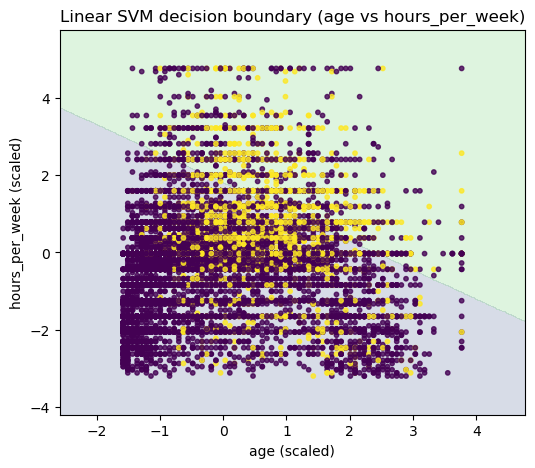

In [21]:
# pick 2 numeric features
FEAT_X, FEAT_Y = "age", "hours_per_week"
X2_train = train_df[[FEAT_X, FEAT_Y]].values
y2_train = pd.Series(y_train).astype(int).values

# scale before fitting
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)

# refit SVM on just these 2 features
svm_2d = LinearSVC(C=best_svm_C if "best_svm_C" in globals() else 1.0, random_state=42, max_iter=2000)
svm_2d.fit(X2_train_scaled, y2_train)

# mesh grid for plotting
x_min, x_max = X2_train_scaled[:,0].min()-1, X2_train_scaled[:,0].max()+1
y_min, y_max = X2_train_scaled[:,1].min()-1, X2_train_scaled[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.2, levels=[-0.5,0.5,1.5])
plt.scatter(X2_train_scaled[:,0], X2_train_scaled[:,1], c=y2_train, s=10, alpha=0.8)
plt.title(f"Linear SVM decision boundary ({FEAT_X} vs {FEAT_Y})")
plt.xlabel(FEAT_X + " (scaled)")
plt.ylabel(FEAT_Y + " (scaled)")
plt.show()